# Tutorial

tradeSeq-py implements the R package tradeSeq {cite}`vandenBerge:20` in Python. In this tutorial, you will learn how to use tradeSeq-py to perform differential expression tests along trajectories.

To demonstrate the appproach, we will use a subset of the scRNA-seq data from {cite}`paul:15`.

## Import packages and load data

In [1]:
# Suppresses warnings related to the installation location of R.
# Should not be necessary on other systems, but in case it is, I'll leave it here to uncomment.
import rpy2.rinterface_lib.callbacks
my_callback = lambda *args: None
rpy2.rinterface_lib.callbacks.consolewrite_warnerror = my_callback

In [2]:
from tradeseq.gam import GAM
from tradeseq.de_tests._start_vs_end_test import StartVsEndTest
from tradeseq.de_tests._association_test import AssociationTest
from tradeseq.de_tests._diff_end_test import DiffEndTest
from tradeseq.de_tests._pattern_test import PatternTest

import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import random

In [3]:
data_path = "data/tutorial_data.h5ad"

adata = ad.read(data_path)
adata

AnnData object with n_obs × n_vars = 2660 × 240
    obsm: 'lineage', 'pseudotime'

Before analyzing the data using tradeSeq-py, we use Scanpy {cite}`wolf:18` to get a first impression of the data. The data comprises two lineages which diverge with increasing pseudotime.

/home/johanna/anaconda3/envs/tradeSeq-py310v2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/johanna/anaconda3/envs/tradeSeq-py310v2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/johanna/anaconda3/envs/tradeSeq-py310v2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


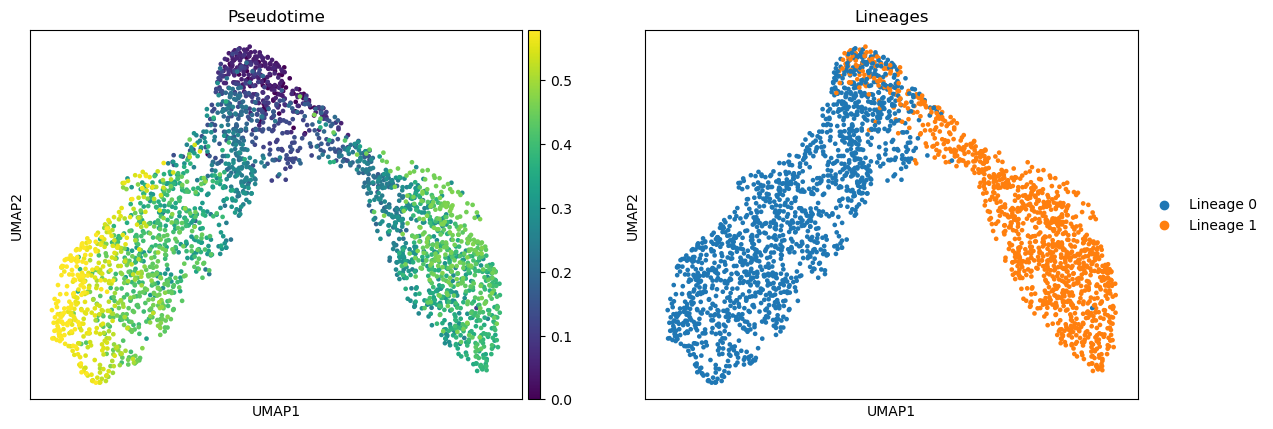

In [4]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

adata.obs["mean_pseudotime"] = np.nanmean(adata.obsm["pseudotime"], axis = 1)
adata.obs["lineage"] = np.where(adata.obsm["lineage"][:,0]==1, "Lineage 0", "Lineage 1")
sc.pl.umap(adata, color=["mean_pseudotime", "lineage"], title = ["Pseudotime", "Lineages"])

## Fit GAM

To fit the generalized additive model (GAM), we need to initialize it first.

In [5]:
weights_key = "lineage"
time_key = "pseudotime"
n_lineages = 2

gam = GAM(adata, n_lineages, time_key, weights_key)

Next, we need to decide on the number of knots. The method {meth}`~tradeseq.gam.GAM.evaluate_n_knots` takes a list of options for the number of knots and returns a dataframe containing the Akaike information criterion (AIC) of genes for the different choices for `n_knots` as well as summarized statistics (see the {meth}`API <tradeseq.gam.GAM.evaluate_n_knots>` for details). These statistics are also represented in the following diagrams.

/home/johanna/anaconda3/envs/tradeSeq-py310v2/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Finished fitting 100 GAMs
Finished fitting 100 GAMs
Finished fitting 100 GAMs


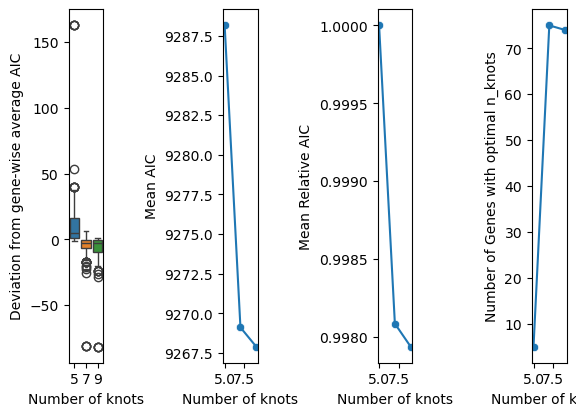

,118,38,230,153,215,211,143,89,167,117,...,123,76,58,75,84,94,Number of knots,Mean AIC,Mean Relative AIC,Number of Genes with optimal n_knots
5,8421.795212,5886.720356,10089.535645,11296.067558,10803.251744,9419.093589,8064.985855,11860.506888,8813.126976,9549.726730,...,7875.048104,8834.529427,9303.182306,8995.676173,10513.280150,12858.889801,5,9288.159249,1.000000,5
7,8424.157418,5888.085001,10064.143665,11251.197042,10802.468638,9393.196583,8056.262400,11854.061925,8806.507787,9547.168948,...,7867.597047,8811.742934,9302.843395,8995.830693,10504.532210,12614.796870,7,9269.119890,0.998087,75
9,8406.291806,5883.807468,10061.854245,11258.640946,10802.519691,9396.891884,8054.980649,11857.969356,8805.840685,9543.730517,...,7865.520814,8808.169384,9302.877218,8995.522667,10506.005242,12614.563009,9,9267.906704,0.997940,74


In [6]:
random.seed(3)
gam.evaluate_n_knots(n_knots_options = [5,7,9], n_vars=100)

/home/johanna/anaconda3/envs/tradeSeq-py310v2/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Finished fitting 100 GAMs
Finished fitting 100 GAMs
Finished fitting 100 GAMs


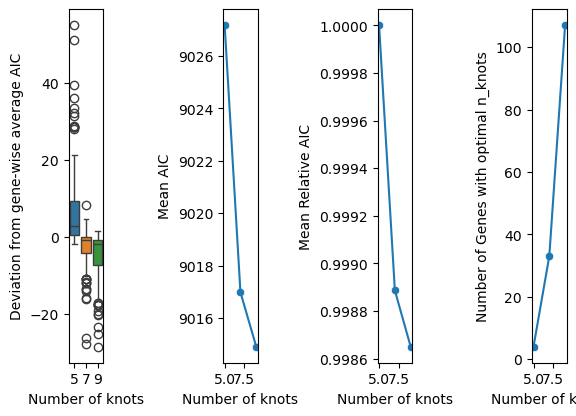

,180,215,114,233,216,199,154,89,147,221,11,80,108,190,6,196,228,92,153,227,51,58,59,46,167,191,57,127,239,212,3,82,34,53,208,206,137,222,206,227,89,145,12,120,194,57,98,201,149,159,216,181,174,209,74,121,195,90,206,194,39,129,23,163,156,3,226,96,73,67,164,173,67,71,31,114,39,78,100,11,28,222,156,185,177,56,85,3,60,147,173,13,223,74,124,57,131,192,218,142,Number of knots,Mean AIC,Mean Relative AIC,Number of Genes with optimal n_knots
5,10395.755691,10726.232627,8505.549307,7447.322739,11221.560548,8845.252637,10415.241286,11859.378269,7900.607518,9094.373243,9902.024319,5655.491353,12146.384559,9045.410709,8939.697809,9684.846643,9347.953950,6129.112410,11432.044396,8578.275312,8868.615717,9426.979327,9248.943887,9458.983634,8829.284050,11678.776494,8708.415995,9517.674682,8144.545214,9535.107955,6806.043085,9485.917822,9751.120774,9763.351767,10845.228411,5152.179394,9926.868840,10130.270662,5152.179394,8578.275312,11859.378269,9109.304569,9197.148422,8704.420207,9640.346615,8708.415995,11232.500983,11836.738665,10300.931885,10110.957233,11221.560548,12449.815219,8995.482568,9212.256015,9822.468617,7012.600944,8981.183922,9202.301952,5152.179394,9640.346615,8797.911927,8721.452169,12684.013359,8235.845116,8856.360923,6806.043085,9661.313607,10175.973871,9423.908633,10172.191989,8646.554797,9179.998616,10172.191989,9260.525402,7893.040288,8505.549307,8797.911927,8279.315741,5506.473565,9902.024319,9463.307427,10130.270662,8856.360923,9148.297005,10012.917177,12089.979528,12477.557611,6806.043085,7931.510097,7900.607518,9179.998616,9066.510553,9768.559243,9822.468617,8734.505538,8708.415995,6259.814028,12993.745485,9321.030299,9756.544405,5,9027.169312,1.000000,4
7,10391.957508,10725.863278,8502.009840,7444.960654,11218.363047,8821.487152,10386.828640,11857.362563,7878.950042,9064.601106,9897.267268,5655.108427,12144.683036,9045.373439,8937.029224,9658.395807,9344.315961,6109.449667,11397.776889,8578.198772,8862.860702,9425.857256,9205.482249,9459.625309,8822.242665,11675.785641,8706.960236,9520.079704,8144.200682,9516.850418,6806.186361,9481.391027,9727.254607,9713.748446,10846.017598,5153.128497,9908.780430,10108.414319,5153.128497,8578.198772,11857.362563,9105.476116,9183.818660,8702.070877,9624.738682,8706.960236,11231.178597,11830.269279,10296.662563,10108.670729,11218.363047,12449.105662,8990.657634,9191.805414,9821.120071,6931.201606,8952.621818,9202.910045,5153.128497,9624.738682,8792.331838,8725.794589,12669.479934,8236.397705,8816.943996,6806.186361,9654.912812,10135.003604,9417.157019,10167.634815,8646.394107,9169.896319,10167.634815,9257.791976,7841.272640,8502.009840,8792.331838,8225.741039,5510.148164,9897.267268,9462.409582,10108.414319,8816.943996,9140.958416,10012.677610,12010.817254,12466.658779,6806.186361,7922.050679,7878.950042,9169.896319,9054.932742,9760.770274,9821.120071,8690.749549,8706.960236,6233.758749,12988.443472,9322.317121,9715.042601,7,9016.982910,0.998886,33
9,10389.643362,10725.675217,8501.497508,7443.953524,11217.951925,8819.401737,10388.612349,11860.470344,7874.762610,9060.168850,9892.974490,5655.228227,12144.013360,9045.691225,8934.029548,9658.536430,9343.845381,6109.954108,11404.533750,8579.058051,8862.225575,9425.941512,9198.259692,9450.102488,8821.364696,11671.054639,8706.369389,9508.381386,8144.166521,9511.266901,6804.148750,9483.480574,9725.265248,9712.728790,10846.125242,5152.134411,9903.563673,10103.397212,5152.134411,8579.058051,11860.470344,9105.390917,9182.949921,8702.152402,9629.799844,8706.369389,11230.224236,11831.176628,10292.847231,10104.886265,11217.951925,12423.511358,8984.928908,9192.869868,9821.321124,6929.041843,8954.202158,9203.219937,5152.134411,9629.799844,8786.518490,8720.598784,12665.083302,8236.359398,8810.149156,6804.148750,9657.104045,10130.383321,9418.002828,10166.894472,8646.690988,9164.074724,10166.894472,9257.547878,7836.884187,8501.497508,8786.518490,8214.753708,5508.738894,9892.974490,9461.020171,10103.397212,8810.149156,9139.423968,10013.333729,12015.31633

In [7]:
# Note: Since dataframes are not displayed nicely in the darkmode of the usual sphinx documentation, 
# this HTML snippet enforces a decent presentation in both dark and light mode. In order to not 
# confuse the reader of the tutorial, the code and its output come from different cells and are 
# duplicated in this notebook. Whether the input or output is shown in the tutorial is decided by tags
# in the respective cells. This method will be applied for all cells which output dataframes.

gam = GAM(adata, n_lineages, time_key, weights_key)
random.seed(3)
eval_result = gam.evaluate_n_knots(n_knots_options = [5,7,9], n_vars=100)

from IPython.display import display, HTML

display(
    HTML(
        "<div style='height: auto; overflow: auto; width: fit-content; max-width: 100%; background-color: LightGrey; color: Black'>" +
        eval_result.to_html() +
        "</div>"
    )
)

Since 9 knots yield the lowest AIC, we decide to fit the GAMs for all genes with `n_knots = 9`.

In [8]:
gam.fit(n_knots = 9)

Finished fitting 240 GAMs


Using {meth}`gam.plot<tradeseq.gam.GAM.plot>`, we see the gene counts and the fitted smoothers for one gene.

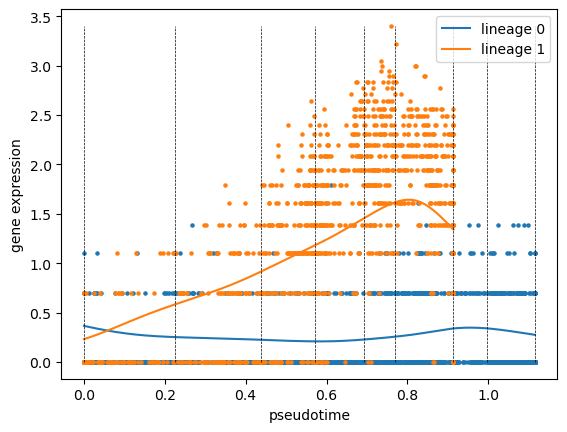

In [9]:
gam.plot(50, log_scale = True)

## Performing Differential Expession Tests

Now, we can use the fitted smoothers to apply DE tests. For each test, additional parameters can be found in the API.

The first two tests compare expression within each lineage, while the last two tests allow comparisons between lineages.

### Association Test

First, we will apply the Association Test, which is testing the null hypothesis that all smoother coefficients are equal to each other. In case they are not equal, the average gene expression is significantly changing with increasing pseudotime.

In [10]:
asso = AssociationTest(gam)
asso_result = asso()
asso_result

globally                                                 
    wald statistic degrees of freedom       p value log fold change
0       155.166819                 16  0.000000e+00       -0.014930
1       616.568141                 16  0.000000e+00       -0.075294
2       111.680641                 16  2.220446e-16       -0.124879
3       203.039080                 16  0.000000e+00       -0.078245
4       985.392571                 16  0.000000e+00       -0.235119
..             ...                ...           ...             ...
235     716.484538                 16  0.000000e+00        0.202663
236     568.647603                 16  0.000000e+00       -0.121648
237      92.150543                 16  1.002975e-12       -0.041522
238     542.301545                 16  0.000000e+00        0.121219
239      48.958548                 16  3.354439e-05       -0.043247

[240 rows x 4 columns]

In [11]:
display(
    HTML(
        "<div style='height: 300px; overflow: auto; width: fit-content; max-width: 100%; background-color: LightGrey; color: Black'>" +
        asso_result.to_html() +
        "</div>"
    )
)

To visualize the estimated smoothers for the genes violating most significantly the null hypothesis, we use the following function.

In [12]:
def plot_top(test_results, test_type = "globally", n_top = 5):
    """Plot the n_top genes with the highest wald statistic"""
    res_ind_ordered = np.argsort(test_results[test_type]["wald statistic"])
    for i in res_ind_ordered[-n_top:]:
        gam.plot(i, alpha = 0.1, log_scale = True, y_label = "gene expression (log scale)")
        print(test_results[test_type].iloc[i])

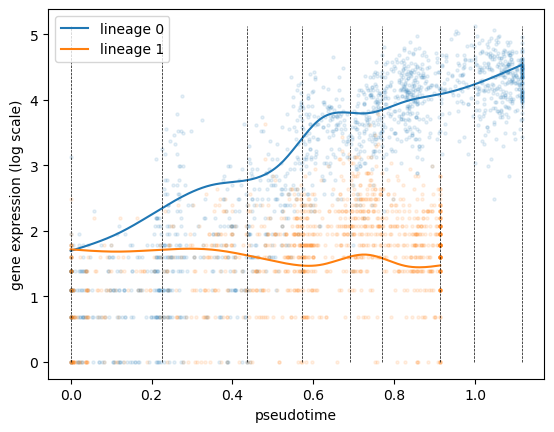

wald statistic        4234.341802
degrees of freedom      16.000000
p value                  0.000000
log fold change         -0.178561
Name: 134, dtype: float64


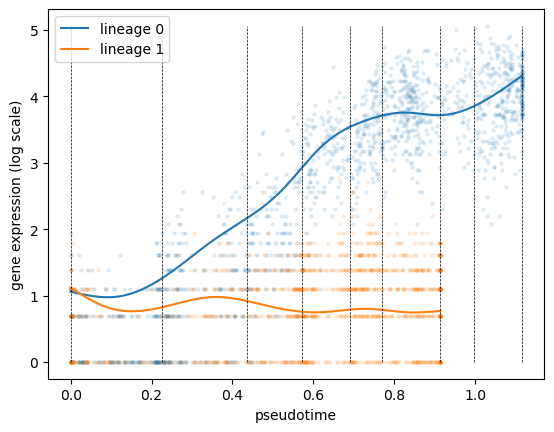

wald statistic        4540.392963
degrees of freedom      16.000000
p value                  0.000000
log fold change         -0.202005
Name: 168, dtype: float64


In [13]:
plot_top(asso_result, n_top=2)

### Start vs End Test

This test compares the expression of genes at two given points of a lineage. It can be used to discover progenitor marker genes.

In [14]:
start_end = StartVsEndTest(gam)
start_end_result = start_end()
start_end_result

globally                                                 
    wald statistic degrees of freedom       p value log fold change
0         3.760239                  2  1.525719e-01       -0.164234
1       225.403172                  2  0.000000e+00       -0.828229
2        64.752043                  2  8.659740e-15       -1.373666
3       102.233245                  2  0.000000e+00       -0.860698
4       425.033476                  2  0.000000e+00       -2.586309
..             ...                ...           ...             ...
235     169.798005                  2  0.000000e+00        2.229294
236     140.994247                  2  0.000000e+00       -1.338129
237       8.394655                  2  1.503571e-02       -0.456738
238      72.608910                  2  2.220446e-16        1.333412
239      13.642882                  2  1.090149e-03       -0.475718

[240 rows x 4 columns]

In [15]:
display(
    HTML(
        "<div style='height: 300px; overflow: auto; width: fit-content; max-width: 100%; background-color: LightGrey; color: Black'>" +
        start_end_result.to_html() +
        "</div>"
    )
)

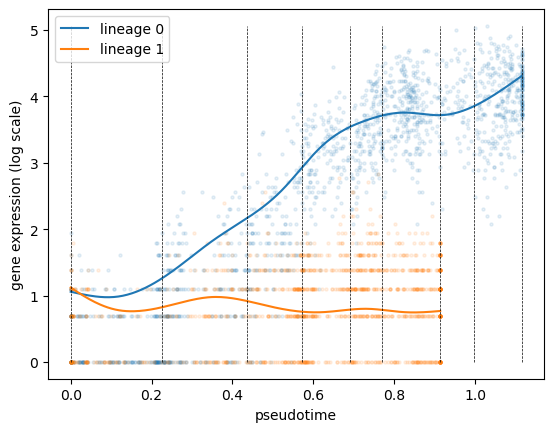

wald statistic        672.273651
degrees of freedom      2.000000
p value                 0.000000
log fold change        -2.222058
Name: 168, dtype: float64


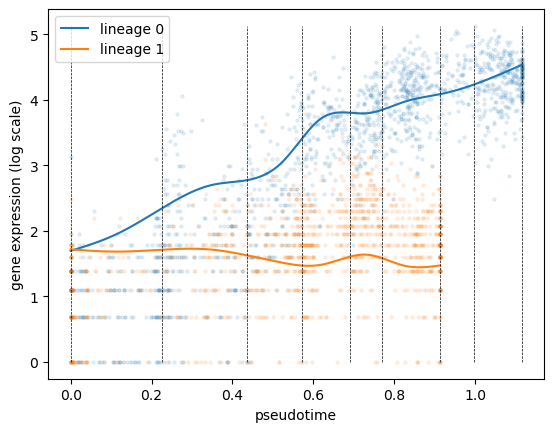

wald statistic        887.800391
degrees of freedom      2.000000
p value                 0.000000
log fold change        -1.964169
Name: 134, dtype: float64


In [16]:
plot_top(start_end_result, n_top=2)

### DiffEnd Test

The DiffEnd Test is the first test that compares properties between lineages. It can help to identify marker genes for the differentiation of cell types.

The DiffEnd Test tests the null hypothesis that the average expression at the endpoints is equal for all lineages using a multivariate Wald test. Again, we will plot the most significant genes.

In [17]:
diff_end = DiffEndTest(gam)
diff_end_result = diff_end()
diff_end_result

globally                                             
    wald statistic degrees of freedom   p value log fold change
0        14.327349                  1  0.000154        0.525248
1       216.841920                  1  0.000000        0.698483
2         9.160883                  1  0.002472       -0.311526
3       301.882687                  1  0.000000       -3.377593
4      1249.520249                  1  0.000000        4.947998
..             ...                ...       ...             ...
235     170.624848                  1  0.000000        3.836133
236       0.096299                  1  0.756317        0.020096
237       9.695697                  1  0.001847       -0.383602
238     189.881352                  1  0.000000       -3.586966
239      17.302611                  1  0.000032       -0.432018

[240 rows x 4 columns]

In [18]:
display(
    HTML(
        "<div style='height: 300px; overflow: auto; width: fit-content; max-width: 100%; background-color: LightGrey; color: Black'>" +
        diff_end_result.to_html() +
        "</div>"
    )
)

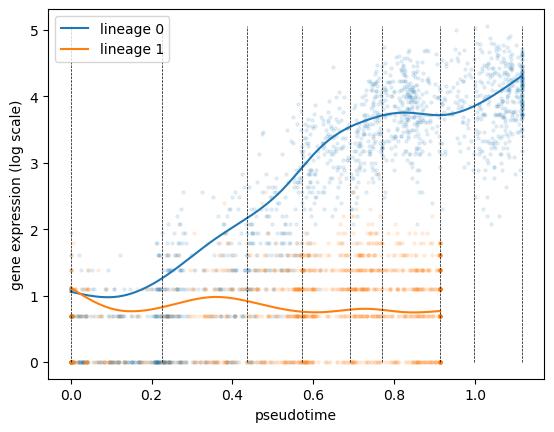

wald statistic        3056.488512
degrees of freedom       1.000000
p value                  0.000000
log fold change          5.988165
Name: 168, dtype: float64


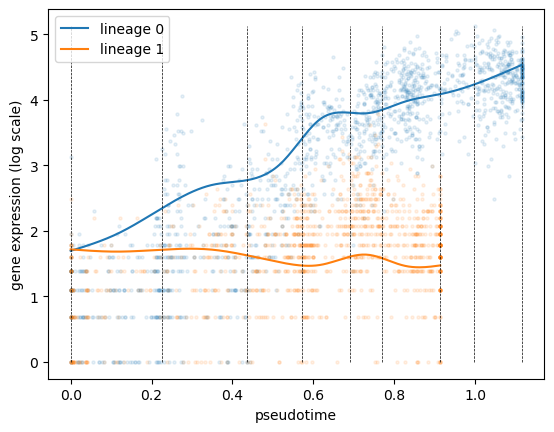

wald statistic        3286.483853
degrees of freedom       1.000000
p value                  0.000000
log fold change          4.774695
Name: 134, dtype: float64


In [19]:
plot_top(diff_end_result, n_top = 2)

### Pattern Test

The Pattern Test evaluates the differences of expression pattern between lineages. It is applied similar as the tests above.

In [20]:
pattern = PatternTest(gam)
pattern_result = pattern()
pattern_result

globally                                                 
    wald statistic degrees of freedom       p value log fold change
0        36.531272                  6  2.172903e-06        0.028655
1       676.378585                  6  0.000000e+00        0.328432
2        69.861827                  6  4.364287e-13       -0.161939
3      1103.108861                  6  0.000000e+00       -1.420393
4      2153.301889                  6  0.000000e+00        2.079930
..             ...                ...           ...             ...
235    1522.786129                  6  0.000000e+00        2.903641
236      44.879065                  6  4.946438e-08       -0.040933
237      13.340902                  6  3.793073e-02       -0.054805
238    1257.055196                  6  0.000000e+00       -2.113037
239     319.933014                  6  0.000000e+00       -0.682509

[240 rows x 4 columns]

In [21]:
display(
    HTML(
        "<div style='height: 300px; overflow: auto; width: fit-content; max-width: 100%; background-color: LightGrey; color: Black'>" +
        pattern_result.to_html() +
        "</div>"
    )
)

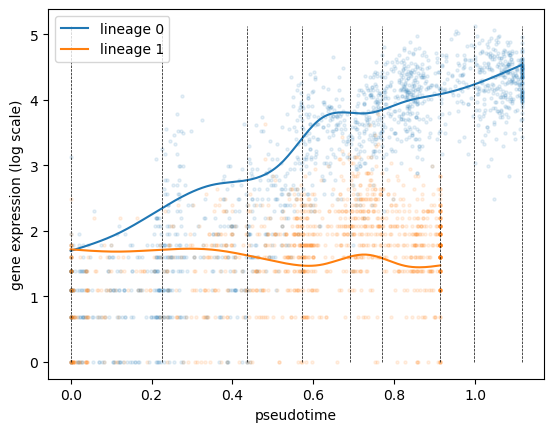

wald statistic        11830.139366
degrees of freedom        6.000000
p value                   0.000000
log fold change           2.506102
Name: 134, dtype: float64


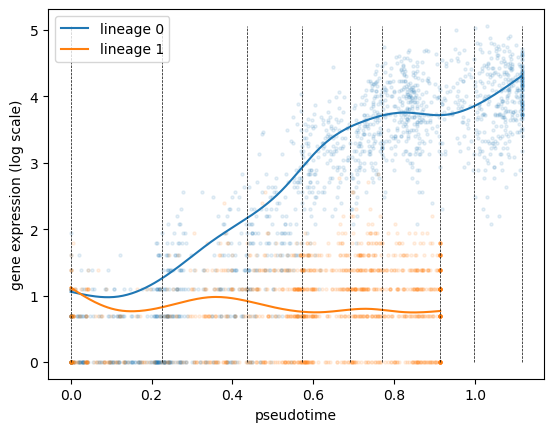

wald statistic        11841.083087
degrees of freedom        6.000000
p value                   0.000000
log fold change           3.166317
Name: 168, dtype: float64


In [22]:
plot_top(pattern_result, n_top=2)

## Conclusion

In this tutorial, you learned
* how to initialize and fit a GAM model and
* how to use it for differential expression analysis within and between lineages.

Next, we recommend that you take a look at the API of the classes which appeared in this tutorial. In the API you can find out more about possible parameters to analyze your data the best way possible.